In [37]:
import os
import random
from pathlib import Path

import pandas as pd
from PIL import Image

# Optional: nicer image display in notebooks
try:
    from IPython.display import display
except Exception:
    display = None


In [ ]:

# === 1) CONFIG ===
CSV_PATH = "../data/images/ihc.csv"# <-- change to your csv filename
BASE_DIR = ".."                             # <-- folder root if your image_path is relative
SAMPLE_N = 5                               # how many rows to test

# Allowed values (safety checks)
ALLOWED_TISSUE_STATE = {"tumor", "normal"}
ALLOWED_PRIORITY = {"core", "future"}


In [ ]:

# === 2) LOAD CSV ===
df = pd.read_csv(CSV_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(3)


Rows: 214
Columns: ['image_id', 'image_path', 'sex', 'cancer', 'gene_symbol', 'ihc_name', 'tissue_state', 'source', 'modality']


image_id                                         image_path sex cancer  \
0  img_001  C:\Users\marie\Desktop\dataset_biocup\lungs\NK...   f   lung   
1  img_002  C:\Users\marie\Desktop\dataset_biocup\lungs\NK...   m   lung   
2  img_003  C:\Users\marie\Desktop\dataset_biocup\lungs\NK...   m   lung   

  gene_symbol ihc_name tissue_state source modality  
0         NaN      NaN       normal    HPA      ihc  
1         NaN      NaN       normal    HPA      ihc  
2         NaN      NaN       normal    HPA      ihc

In [40]:
# === 3) BASIC VALIDATION (fast sanity checks) ===

required_cols = [
    "image_id", "image_path", "cancer",
    "gene_symbol", "ihc_name", "tissue_state",
    "source", "modality"
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Check tissue_state values
bad_states = sorted(set(df["tissue_state"].astype(str)) - ALLOWED_TISSUE_STATE)
if bad_states:
    raise ValueError(f"Unexpected tissue_state values found: {bad_states}")


# Check empty critical fields
for c in ["image_id", "image_path", "cancer", "tissue_state"]:
    if df[c].isna().any():
        n = int(df[c].isna().sum())
        raise ValueError(f"Column '{c}' has {n} missing values.")

print("✅ CSV basic checks passed.")


✅ CSV basic checks passed.


In [41]:
# === 4) CHECK THAT IMAGE FILES EXIST ===

def resolve_path(p: str) -> Path:
    p = str(p).strip()
    path = Path(p)
    if not path.is_absolute():
        path = Path(BASE_DIR) / path
    return path

df["_resolved_path"] = df["image_path"].apply(resolve_path)
missing_files = df[~df["_resolved_path"].apply(lambda p: p.exists())]

print("Missing files:", len(missing_files))
if len(missing_files) > 0:
    missing_files[["image_id", "image_path", "_resolved_path"]].head(10)


Missing files: 0


In [42]:
missing_files[["image_id", "image_path", "_resolved_path"]]

Empty DataFrame
Columns: [image_id, image_path, _resolved_path]
Index: []

In [43]:
# === 5) SELECT A SMALL SAMPLE (only rows whose files exist) ===

df_ok = df[df["_resolved_path"].apply(lambda p: p.exists())].copy()
if len(df_ok) == 0:
    raise RuntimeError("No valid images found. Fix image_path / BASE_DIR first.")

sample_df = df_ok.sample(min(SAMPLE_N, len(df_ok)), random_state=42)
sample_df[["image_id", "cancer", "gene_symbol", "ihc_name", "tissue_state", "_resolved_path"]]


image_id  cancer gene_symbol ihc_name tissue_state  \
9    img_010    lung      NKX2-1    TTF-1        tumor   
197  img_198   colon         NaN      NaN       normal   
66   img_067   liver         NaN      NaN       normal   
191  img_192   colon         NaN      NaN       normal   
117  img_118  breast         PGR       PR        tumor   

                                        _resolved_path  
9    C:\Users\marie\Desktop\dataset_biocup\lungs\NK...  
197  C:\Users\marie\Desktop\dataset_biocup\colon\KR...  
66   C:\Users\marie\Desktop\dataset_biocup\liver\no...  
191  C:\Users\marie\Desktop\dataset_biocup\colon\CD...  
117  C:\Users\marie\Desktop\dataset_biocup\Breast\P...

- img_010 | lung | NKX2-1 | tumor | size=(317, 233)


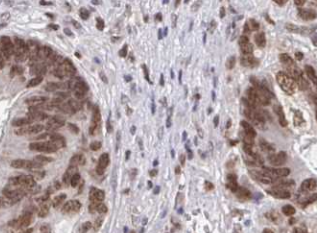

- img_198 | colon | nan | normal | size=(762, 620)


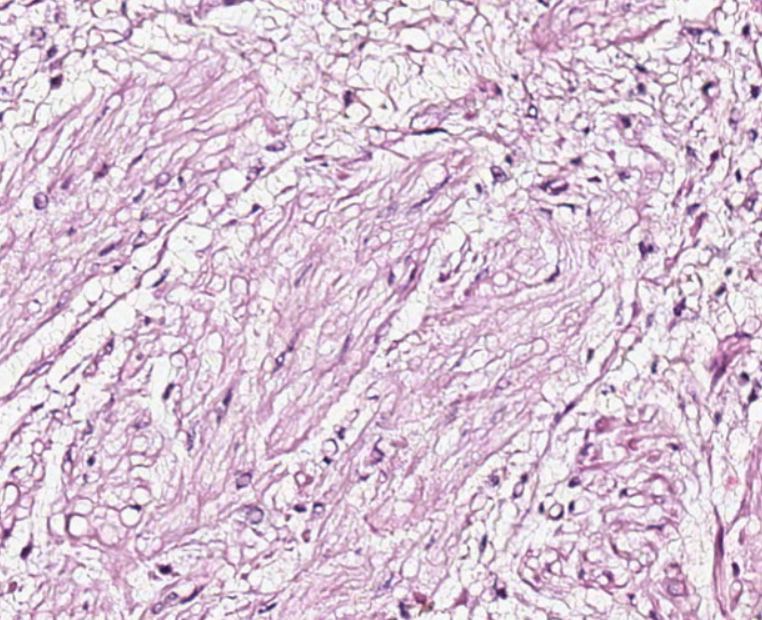

- img_067 | liver | nan | normal | size=(798, 622)


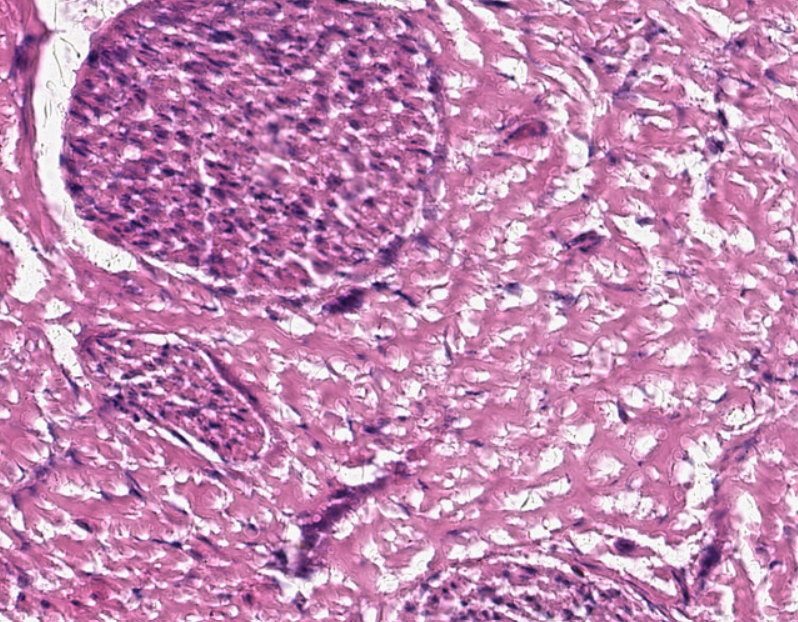

- img_192 | colon | nan | normal | size=(758, 637)


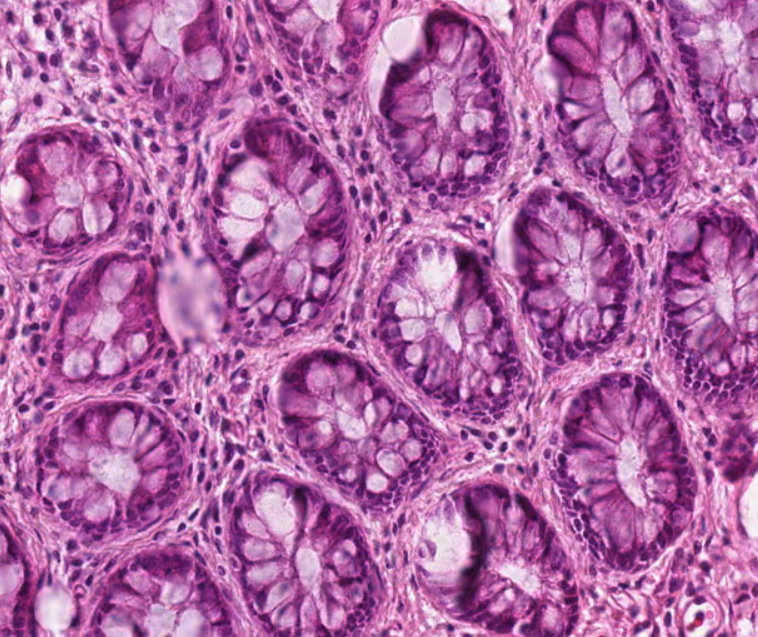

- img_118 | breast | PGR | tumor | size=(371, 190)


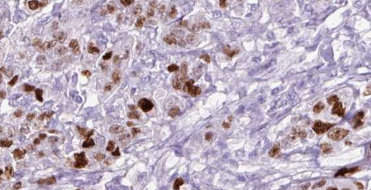

In [44]:
# === 6) LOAD + DISPLAY IMAGES (quick visual check) ===

def load_image_rgb(path: Path) -> Image.Image:
    img = Image.open(path)
    return img.convert("RGB")

for _, row in sample_df.iterrows():
    path = row["_resolved_path"]
    img = load_image_rgb(path)
    print(f"- {row['image_id']} | {row['cancer']} | {row['gene_symbol']} | {row['tissue_state']} | size={img.size}")
    if display is not None:
        display(img)


In [45]:
# === 7) EMBEDDING FUNCTION (plug YOUR code here) ===
# Replace embed_image(...) with your own embedding code.
# The function must return a 1D list/np.array of floats.
#Dans la cellule (7), remplace la fonction embed_image(img) par ton code actuel.

import numpy as np

def embed_image(img: Image.Image) -> np.ndarray:
    """
    TODO: Replace this dummy embedding with your real model.
    Must return shape: (D,)
    """
    # Dummy example: DON'T use in production
    # Creates a stable random vector based on image size (just for testing pipeline)
    rng = np.random.default_rng(seed=img.size[0] * 100000 + img.size[1])
    return rng.normal(size=(512,)).astype(np.float32)

# Quick check on one image
test_vec = embed_image(load_image_rgb(sample_df.iloc[0]["_resolved_path"]))
print("Embedding dim:", test_vec.shape, "dtype:", test_vec.dtype)


Embedding dim: (512,) dtype: float32


In [46]:
# === 8) BUILD PAYLOAD FROM CSV (no manual typing!) ===

def build_payload(row: pd.Series) -> dict:
    # Keep it clean + consistent
    payload = {
        "cancer": str(row["cancer"]),
        "tissue_state": str(row["tissue_state"]),
        "source": str(row["source"]),
        "modality": str(row["modality"]),
    }

    gene = str(row["gene_symbol"])
    ihc  = str(row["ihc_name"])

    # If you use NA for normals, keep it consistent
    if gene.upper() not in {"NA", "NONE", "NAN"}:
        payload["gene_symbol"] = gene
    if ihc.upper() not in {"NA", "NONE", "NAN"}:
        payload["ihc_name"] = ihc

    return payload

# Preview payloads for sample rows
for _, row in sample_df.iterrows():
    print(row["image_id"], "->", build_payload(row))


img_010 -> {'cancer': 'lung', 'tissue_state': 'tumor', 'source': 'HPA', 'modality': 'ihc', 'gene_symbol': 'NKX2-1', 'ihc_name': 'TTF-1'}
img_198 -> {'cancer': 'colon', 'tissue_state': 'normal', 'source': 'HPA', 'modality': 'ihc'}
img_067 -> {'cancer': 'liver', 'tissue_state': 'normal', 'source': 'HPA', 'modality': 'ihc'}
img_192 -> {'cancer': 'colon', 'tissue_state': 'normal', 'source': 'HPA', 'modality': 'ihc'}
img_118 -> {'cancer': 'breast', 'tissue_state': 'tumor', 'source': 'HPA', 'modality': 'ihc', 'gene_symbol': 'PGR', 'ihc_name': 'PR'}


In [47]:
# === 9) DRY RUN: COMPUTE EMBEDDINGS + SHOW FINAL OBJECTS ===

results = []
for _, row in sample_df.iterrows():
    img = load_image_rgb(row["_resolved_path"])
    vec = embed_image(img)
    payload = build_payload(row)

    # Quick validation
    if vec.ndim != 1:
        raise ValueError(f"Embedding must be 1D. Got shape={vec.shape} for image_id={row['image_id']}")
    if not np.isfinite(vec).all():
        raise ValueError(f"Embedding has NaN/Inf for image_id={row['image_id']}")

    results.append({
        "image_id": row["image_id"],
        "path": str(row["_resolved_path"]),
        "dim": int(vec.shape[0]),
        "payload": payload,
    })

pd.DataFrame(results)


image_id                                               path  dim  \
0  img_010  C:\Users\marie\Desktop\dataset_biocup\lungs\NK...  512   
1  img_198  C:\Users\marie\Desktop\dataset_biocup\colon\KR...  512   
2  img_067  C:\Users\marie\Desktop\dataset_biocup\liver\no...  512   
3  img_192  C:\Users\marie\Desktop\dataset_biocup\colon\CD...  512   
4  img_118  C:\Users\marie\Desktop\dataset_biocup\Breast\P...  512   

                                             payload  
0  {'cancer': 'lung', 'tissue_state': 'tumor', 's...  
1  {'cancer': 'colon', 'tissue_state': 'normal', ...  
2  {'cancer': 'liver', 'tissue_state': 'normal', ...  
3  {'cancer': 'colon', 'tissue_state': 'normal', ...  
4  {'cancer': 'breast', 'tissue_state': 'tumor', ...

In [48]:
# === 10) OPTIONAL: CHECK CONSISTENCY (all embeddings same dimension) ===
dims = [r["dim"] for r in results]
print("Dims in sample:", dims)
if len(set(dims)) != 1:
    raise ValueError(f"❌ Embedding dimensions differ in the sample: {set(dims)}")
print("✅ Embedding dimensions consistent in the sample.")


Dims in sample: [512, 512, 512, 512, 512]
✅ Embedding dimensions consistent in the sample.
